### HANDELING ORIGINAL FILES

## ISDS

In [ ]:
import pandas as pd
import re
import country_converter as coco
import numpy as np

# Loading the UNCTAD ISDS navigator data
path = "UNCTAD-ISDS-Navigator-data-set-31December2023.xlsx"
raw_df = pd.read_excel(path, header=11)

# feature selection and renaming them
df = raw_df[[
    "RESPONDENT STATE",
    "HOME STATE OF INVESTOR",
    "ECONOMIC SECTOR",
    "ECONOMIC SUBSECTOR",
    "SUMMARY OF THE DISPUTE",
    "AMOUNT CLAIMED (EXPRESSED IN MILLIONS)",
    "YEAR OF INITIATION"
]].rename(columns={
    "RESPONDENT STATE": "respondent_state",
    "HOME STATE OF INVESTOR": "investor_home_state",
    "ECONOMIC SECTOR": "economic_sector",
    "ECONOMIC SUBSECTOR": "economic_subsector",
    "SUMMARY OF THE DISPUTE": "summary_of_dispute",
    "AMOUNT CLAIMED (EXPRESSED IN MILLIONS)": "amount_claimed_raw",
    "YEAR OF INITIATION": "year"
})

# Cleaning features, so that they are comparable and ready for numerical analysis

def parse_claim_amount(x):
    if pd.isna(x): return None
    s = str(x).replace(",", "")
    m = re.search(r"\(\s*([0-9]+(?:\.[0-9]+)?)\s*USD\s*\)", s)
    if m: return float(m.group(1))
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)\s*USD\b", s)
    if m: return float(m.group(1))
    return None

df["amount_claimed_musd"] = df["amount_claimed_raw"].apply(parse_claim_amount)
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# STRIP PRIMARY/SECONDARY/TERTIARY FROM ECONOMIC_SECTOR
# This changes "Primary - A - Agriculture..." to "A - Agriculture..."
df['economic_sector'] = df['economic_sector'].str.replace(r'^(Primary|Secondary|Tertiary)\s*-\s*', '', regex=True)

# GEOSPATIAL HARMONIZATION (getting ISO3 CODES) using the country_converter import

cc = coco.CountryConverter()
ISO_CACHE = {}

def get_iso3_codes(country_string):
    if pd.isna(country_string): return None
    s = str(country_string).strip()
    if s.lower() in ["data not available", "selection deleted", "european union", ""]:
        return None
    countries = [c.strip() for c in s.split(";\n") if c.strip()]
    codes = []
    for c in countries:
        if c not in ISO_CACHE:
            res = cc.convert(names=c, to="ISO3", not_found=None)
            ISO_CACHE[c] = res
        if ISO_CACHE[c] and ISO_CACHE[c] != "not found":
            codes.append(ISO_CACHE[c])
    return "; ".join(sorted(set(codes))) if codes else None

for col in ["respondent_state", "investor_home_state"]:
    df[f"{col}_iso3"] = df[col].apply(get_iso3_codes)

# BINARY ENCODING FOR ECONOMIC SECTORS

# letters A through O are all the NACE level sectors
ISDS_LETTERS = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O"]

for let in ISDS_LETTERS:
    # Column names are clean: 'sector_A', 'sector_B', etc.
    col_name = f"sector_{let}"
    # Match if sector text starts with the letter (e.g., "A - ...") or contains it after a semicolon
    df[col_name] = df['economic_sector'].apply(lambda x: 1 if re.search(rf"(^|;\s*){let}\b", str(x)) else 0)

# FINAL EXPORT
df.to_csv("ISDS_processed_dataset_final.csv", index=False)

print(f"Pipeline complete. Dimensions: {df.shape}")

## Landmatrix

In [ ]:

# Loading in the landmatrix data
deals = pd.read_csv('deals.csv', sep=';', low_memory=False)
contracts = pd.read_csv('contracts.csv', sep=';', low_memory=False)
locations = pd.read_csv('locations.csv', sep=';', low_memory=False)
investors = pd.read_csv('investors.csv', sep=';', low_memory=False)

# 1. DATA INTEGRATION (merging all the different files together)
investors_df = investors.add_prefix('Investor_')

merged_df = deals.merge(contracts[['Deal ID', 'Contract date']], on='Deal ID', how='left')
merged_df = merged_df.merge(locations[['Deal ID', 'Spatial accuracy level', 'Point']], on='Deal ID', how='left')
merged_df = merged_df.merge(
    investors_df[['Investor_Investor ID', 'Investor_Country of registration/origin']], 
    left_on='Operating company: Investor ID', 
    right_on='Investor_Investor ID', 
    how='left'
)
#selecting the target features
target_features = [
    'Deal ID', 'Target country', 'Deal size', 'Deal scope', 'Intention of investment',
    'Current negotiation status', 'Current implementation status', 'Created at',
    'Presence of land conflicts', 'Displacement of people', 'Spatial accuracy level',
    'Point', 'Nature of the deal', 'Carbon offset project',
    'Operating company: Country of registration/origin',
    'Investor_Country of registration/origin'
]

df = merged_df[target_features].copy()

# Mapping errors in the dataset
TRUNCATION_MAP = {
    "Oth": "Other", "Fodd": "Fodder", "Conservatio": "Conservation",
    "Land speculatio": "Land speculation", "Oil / Gas extractio": "Oil / Gas extraction"
}
# SECTOR HARMONIZATION (Taxonomy mapping using NACE )
#This is not NACE yet, this is used to clean the column
SECTOR_TAXONOMY = {
    "Food crops": "Food crops", "Livestock": "Livestock", "Mining": "Mining",
    "Non-food agricultural commodities": "Non-food agricultural commodities",
    "Biomass for biofuels": "Biomass for biofuels", "Fodder": "Fodder",
    "Oil / Gas extraction": "Oil / Gas extraction", 
    "Forest logging / management": "Forestry Management",
    "Timber plantation": "Timber Plantation", "Wind farm": "Wind Farm",
    "Solar park": "Solar Park", "Renewable energy": "Renewable Energy",
    "For carbon sequestration/REDD": "Carbon Sequestration / REDD",
    "Industry": "Industry", "Tourism": "Tourism", "Land speculation": "Land speculation",
    "Agriculture unspecified": "Agriculture Unspecified", "Conservation": "Conservation"
}


def clean_sectors(raw_val):
    if pd.isna(raw_val): return ""
    s = str(raw_val).strip()
    s = re.sub(r"\|[0-9#.\-a-zA-Z]*", "", s)
    if "#" in s:
        s = re.sub(r"^.*#(?!.*#)", "", s).lstrip("#")
    for bad, good in TRUNCATION_MAP.items():
        s = s.replace(bad, good)
    parts = re.split(r"\s*,\s*", s)
    matches = []
    for p in parts:
        for key, val in SECTOR_TAXONOMY.items():
            if key.lower() in p.lower():
                matches.append(val)
    return "; ".join(sorted(set(matches)))

df['sectors_cleaned'] = df['Intention of investment'].apply(clean_sectors)

# Standardizing the 18 sectors to the 16-Sector Taxonomy and NACE codes
NACE_MAP = {
    "Agriculture Unspecified": ("1. Agriculture & Livestock", "A - Agriculture, forestry and fishing", "01"),
    "Fodder": ("1. Agriculture & Livestock", "A - Agriculture, forestry and fishing", "01"),
    "Food crops": ("1. Agriculture & Livestock", "A - Agriculture, forestry and fishing", "01"),
    "Livestock": ("1. Agriculture & Livestock", "A - Agriculture, forestry and fishing", "01"),
    "Non-food agricultural commodities": ("1. Agriculture & Livestock", "A - Agriculture, forestry and fishing", "01"),
    "Forestry Management": ("2. Forestry Timber & Logging", "A - Agriculture, forestry and fishing", "02"),
    "Timber Plantation": ("2. Forestry Timber & Logging", "A - Agriculture, forestry and fishing", "02"),
    "Carbon Sequestration / REDD": ("3. Forestry - Carbon & Conservation", "A - Agriculture, forestry and fishing", "02"),
    "Conservation": ("3. Forestry - Carbon & Conservation", "A - Agriculture, forestry and fishing", "02"),
    "Mining": ("5. Mining & Quarrying", "B - Mining and quarrying", "07/08"),
    "Oil / Gas extraction": ("6. Oil & Gas Extraction", "B - Mining and quarrying", "06"),
    "Biomass for biofuels": ("7. Biofuels & Biomass Energy", "C - Manufacturing", "20"),
    "Renewable Energy": ("8. Renewable Energy (non-biomass)", "D - Electricity, gas, steam and air conditioning supply", "35"),
    "Solar Park": ("8. Renewable Energy (non-biomass)", "D - Electricity, gas, steam and air conditioning supply", "35"),
    "Wind Farm": ("8. Renewable Energy (non-biomass)", "D - Electricity, gas, steam and air conditioning supply", "35"),
    "Industry": ("10. Manufacturing & Processing", "C - Manufacturing", "10-33"),
    "Land speculation": ("11. Construction & Real Estate", "L - Real estate activities", "68"),
    "Tourism": ("15. Tourism & Hospitality", "I - Accommodation and food service activities", "55")
}

def map_to_nace(val):
    if not val: return "N/A", "N/A", "N/A"
    uni, sec, sub = set(), set(), set()
    for key, (u_name, n_sec, n_sub) in NACE_MAP.items():
        if key in str(val):
            uni.add(u_name); sec.add(n_sec); sub.add(n_sub)
    return "; ".join(sorted(uni)) or "N/A", "; ".join(sorted(sec)) or "N/A", "; ".join(sorted(sub)) or "N/A"

df[['sectors_unified', 'nace_sector', 'nace_subsector']] = df['sectors_cleaned'].apply(lambda x: pd.Series(map_to_nace(x)))

# Standard binary column names (sector_A, sector_B, etc.)
LETTERS = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O"]
for let in LETTERS:
    col_name = f"sector_{let}"
    df[col_name] = df['nace_sector'].apply(lambda x: 1 if re.search(rf"(^|;\s*){let}\b", str(x)) else 0)

# GEOSPATIAL HARMONIZATION (getting ISO3 country codes)
cc = coco.CountryConverter()
ISO_CACHE = {}

def get_iso3_codes(country_string):
    if pd.isna(country_string): return None
    s = str(country_string).strip()
    if s.lower() in ["data not available", "selection deleted", "european union", ""]:
        return None
    countries = [c.strip() for c in s.split(";\n") if c.strip()]
    codes = []
    for c in countries:
        if c not in ISO_CACHE:
            res = cc.convert(names=c, to="ISO3", not_found=None)
            ISO_CACHE[c] = res
        if ISO_CACHE[c] and ISO_CACHE[c] != "not found":
            codes.append(ISO_CACHE[c])
    return "; ".join(sorted(set(codes))) if codes else None

COUNTRY_COLS = ["Target country", "Operating company: Country of registration/origin", "Investor_Country of registration/origin"]
for col in COUNTRY_COLS:
    df[f"{col}_iso3"] = df[col].apply(get_iso3_codes)

# DOWNLOADING FILE
df.to_csv('landmatrix_final_analytical_dataset.csv', index=False)

print(f"Pipeline complete. Dataset dimensions: {df.shape}")
print("Final file saved as: landmatrix_final_analytical_dataset.csv")

## Climate 

In [ ]:
import pandas as pd
import os
from pathlib import Path

# Configuration
input_folder = "path/to/your/csv/folder"  # Change this to your folder path
output_file = "combined_climate_data.csv"  # Output file name

# Columns to keep
columns_to_keep = [
    'Bundle ID(s)',  # Needed for deduplication
    'Case Filing Year for Action',
    'Status',
    'Case Categories',
    'Geographies'
    # Add 'sector' column name here if you identify it
]

# Initialize list to store dataframes
all_data = []

# Process each CSV file in the folder
for csv_file in Path(input_folder).glob("*.csv"):
    print(f"Processing: {csv_file.name}")
    
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Add a category column based on the filename (without extension)
    category_name = csv_file.stem  # stem gives filename without extension
    df['Category'] = category_name
    
    # Keep only the columns we need
    df = df[columns_to_keep + ['Category']]
    
    # Add to our list
    all_data.append(df)
    print(f"  Loaded {len(df)} rows from {csv_file.name}")

# Combine all dataframes
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal rows before processing: {len(combined_df)}")

# Create a binary indicator for each category
combined_df['value'] = 1

# Pivot to create category columns
category_pivot = combined_df.pivot_table(
    index='Bundle ID(s)',
    columns='Category',
    values='value',
    aggfunc='max',
    fill_value=0
).reset_index()

# Get the other columns (take first occurrence for each Bundle ID)
other_columns = combined_df.drop(columns=['Category', 'value']).drop_duplicates(subset='Bundle ID(s)', keep='first')

# Merge everything together
final_df = other_columns.merge(category_pivot, on='Bundle ID(s)')

print(f"Total unique cases: {len(final_df)}")

# Save the result
final_df.to_csv(output_file, index=False)
print(f"\nSaved to: {output_file}")

# Show which cases appear in multiple categories
category_columns = [col for col in final_df.columns if col not in columns_to_keep]
final_df['total_categories'] = final_df[category_columns].sum(axis=1)

print("\nCases appearing in multiple categories:")
print(final_df[final_df['total_categories'] > 1]['total_categories'].value_counts().sort_index())

print("\nCategory column summary:")
for col in category_columns:
    print(f"  {col}: {final_df[col].sum()} cases")






# Loading the combined climate litigation data
df = pd.read_csv('combined_climate_data.csv')

# 2. TAXONOMY MAPPING (sectors_unified)

def get_sectors_unified(row):
    """Maps binary indicators to standardized NACE names."""
    mapping = {
        'agriculture': "1. Agriculture & Livestock",
        'forestry': "2. Forestry Timber & Logging",
        'fishing': "4. Fishing & Aquaculture",
        'extractive': "5. Mining & Quarrying",
        'manufacturing': "10. Manufacturing & Processing",
        'energy_supply': "9. Fossil Energy & Utilities",
        'water_management': "9. Fossil Energy & Utilities",
        'enviromental_management': "3. Forestry - Carbon & Conservation",
        'construction': "11. Construction & Real Estate",
        'trade': "14. Finance & Business Services",
        'transportation_logistics': "12. Transportation & Logistics",
        'media': "13. ICT & Media",
        'finance_insurance': "14. Finance & Business Services",
        'public': "16. Public & Social Services",
        'education': "16. Public & Social Services",
        'informal': "16. Public & Social Services"
    }
    matches = [name for col, name in mapping.items() if row[col] == 1]
    return "; ".join(sorted(set(matches))) if matches else "N/A"

df['sectors_unified'] = df.apply(get_sectors_unified, axis=1)

# 3. BINARY ENCODING (NACE Letters)

# Collapsing the 16 indicators into standardized NACE sector columns (sector_A to sector_O)
df['sector_A'] = df[['agriculture', 'forestry', 'fishing']].max(axis=1)
df['sector_B'] = df['extractive']
df['sector_C'] = df['manufacturing']
df['sector_D'] = df['energy_supply']
df['sector_E'] = df[['enviromental_management', 'water_management']].max(axis=1)
df['sector_F'] = df['construction']
df['sector_G'] = df['trade']
df['sector_H'] = df['transportation_logistics']
df['sector_I'] = 0
df['sector_J'] = df['media']
df['sector_K'] = df['finance_insurance']
df['sector_L'] = 0
df['sector_M'] = 0
df['sector_N'] = 0
df['sector_O'] = df[['public', 'education', 'informal']].max(axis=1)

# Removing original indicator columns to keep only the unified/NACE columns
old_cols = ['agriculture', 'construction', 'education', 'energy_supply', 
            'enviromental_management', 'extractive', 'finance_insurance', 
            'fishing', 'forestry', 'informal', 'manufacturing', 'media', 
            'public', 'trade', 'transportation_logistics', 'water_management']
df = df.drop(columns=old_cols)

# FINAL EXPORT

df.to_csv('climate_litigation_final_unified.csv', index=False)

print(f"Pipeline complete. Dimensions: {df.shape}")
print("Final file saved with 'sectors_unified' and standardized NACE binaries.")

### DATA ANALYSIS

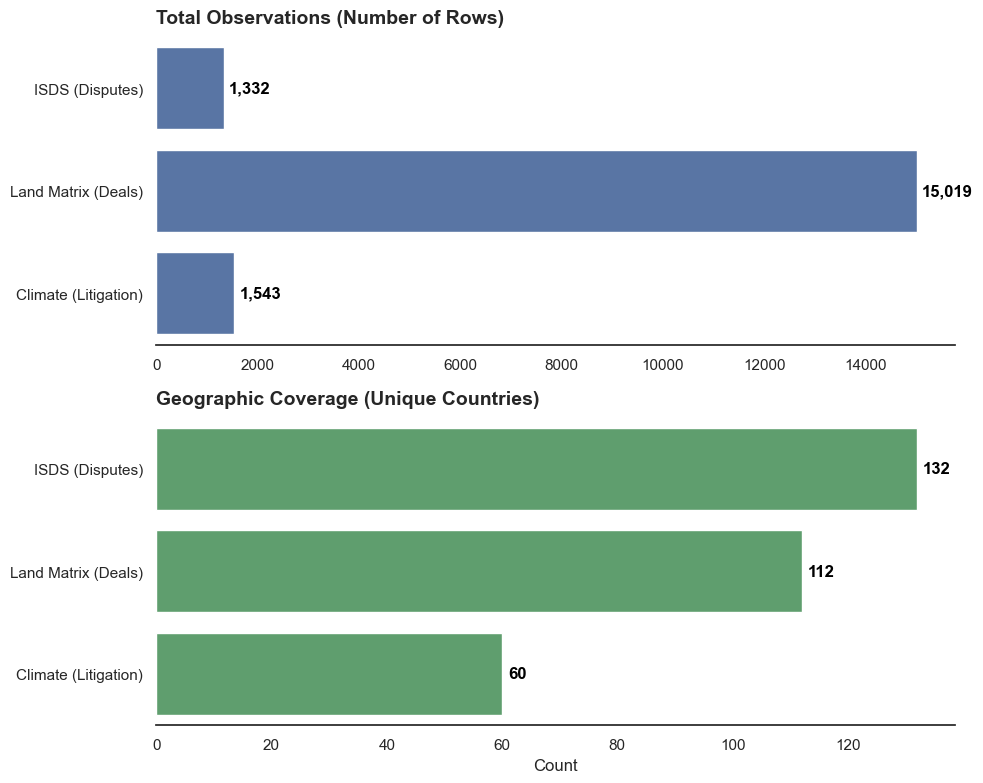

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the primary datasets
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
climate = pd.read_csv('climate_litigation_final_unified.csv')

# Standardizing ISO3 Country Codes for analysis
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
# For climate, only taking the first valueof geographies field
climate['iso3'] = climate['Geographies'].str.split(';').str[0].str.strip().str.upper()

# Calculate some basic metrics
rows_isds = len(isds)
countries_isds = isds['resp_iso3'].nunique()

rows_land = len(land)
countries_land = land['iso3'].nunique()

rows_climate = len(climate)
countries_climate = climate['iso3'].nunique()

# store the data together in df
data = {
    'Dataset': ['ISDS (Disputes)', 'Land Matrix (Deals)', 'Climate (Litigation)'],
    'Rows': [rows_isds, rows_land, rows_climate],
    'Unique Countries': [countries_isds, countries_land, countries_climate]
}
df_stats = pd.DataFrame(data)

# plotting the data
sns.set_theme(style="white")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Total observations (just number of Rows)
sns.barplot(x='Rows', y='Dataset', data=df_stats, ax=ax1, color='#4c72b0')
ax1.set_title('Total Observations (Number of Rows)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

#labelling
for i, v in enumerate(df_stats['Rows']):
    ax1.text(v + 100, i, f'{v:,}', color='black', va='center', fontweight='bold')

# Subplot 2: Geographic coverage (amount of unique Countries)
sns.barplot(x='Unique Countries', y='Dataset', data=df_stats, ax=ax2, color='#55a868')
ax2.set_title('Geographic Coverage (Unique Countries)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('')

for i, v in enumerate(df_stats['Unique Countries']):
    ax2.text(v + 1, i, f'{v}', color='black', va='center', fontweight='bold')

# Removing top/right borders
sns.despine(left=True, bottom=False)
plt.tight_layout()

# Saving and showing the plot
plt.savefig('dataset_overview_comparison.png', dpi=600)
plt.show()

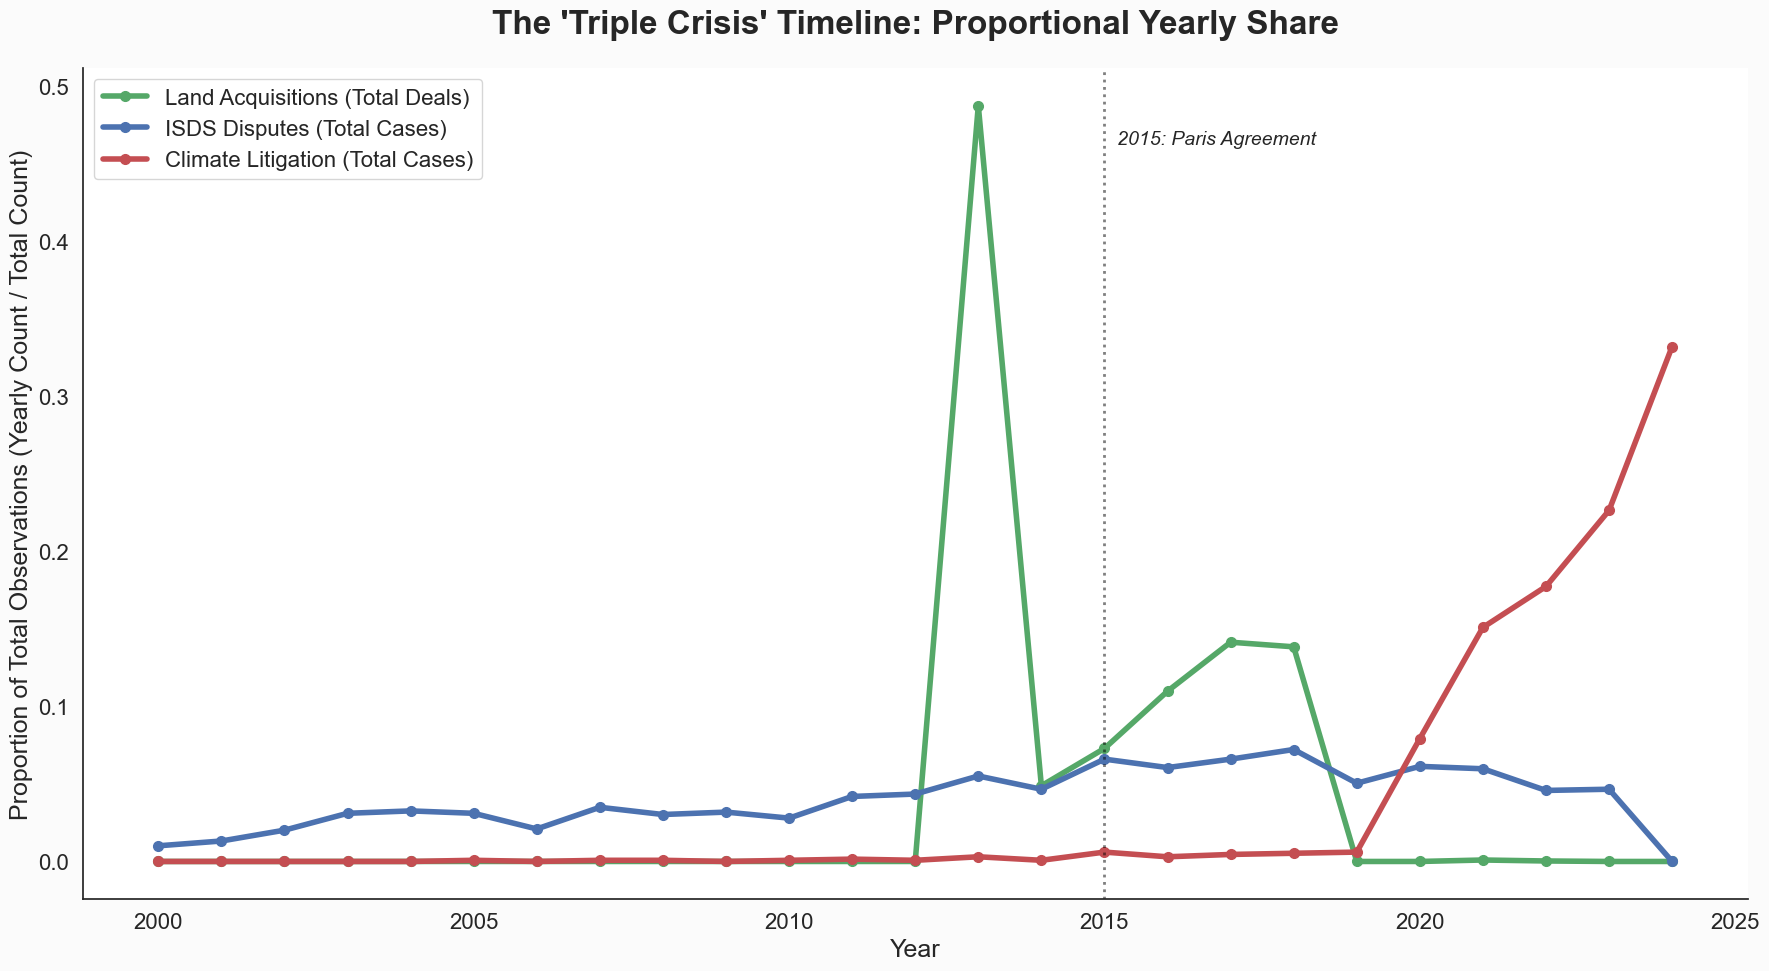

In [4]:
import numpy as np

# Setting standard parameters
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 24,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16
})


# Extracting years from each dataset and counting the amount of entries
# ISDS uses 'year'
isds_years = pd.to_numeric(isds['year'], errors='coerce').dropna().astype(int)
isds_counts = isds_years.value_counts().sort_index()

# Land Matrix uses 'Created at'
land_years = pd.to_datetime(land['Created at'], errors='coerce').dt.year.dropna().astype(int)
land_counts = land_years.value_counts().sort_index()

# Climate Litigation uses 'Case Filing Year for Action'
climate_years = pd.to_numeric(climate['Case Filing Year for Action'], errors='coerce').dropna().astype(int)
climate_counts = climate_years.value_counts().sort_index()

# Creating a unified dataframe for the years 2000 to 2024
years_range = np.arange(2000, 2025)
data = pd.DataFrame({'Year': years_range})

# Merge the counts into the main dataframe
data = data.merge(land_counts.rename('Land'), left_on='Year', right_index=True, how='left').fillna(0)
data = data.merge(isds_counts.rename('ISDS'), left_on='Year', right_index=True, how='left').fillna(0)
data = data.merge(climate_counts.rename('Climate'), left_on='Year', right_index=True, how='left').fillna(0)

# Normalizing by the total sum so we get a proportional share that we can plot together
for col in ['Land', 'ISDS', 'Climate']:
    data[f'{col}_norm'] = data[col] / data[col].sum()

# plotting
plt.figure(figsize=(18, 10), facecolor='#fbfbfb')  # bigger figure
sns.set_style("white")

# Plotting the normalized lines using bigger linewidth + markers
plt.plot(
    data['Year'], data['Land_norm'],
    label='Land Acquisitions (Total Deals)',
    color='#55A868', linewidth=4, marker='o', markersize=7)
plt.plot(
    data['Year'], data['ISDS_norm'],
    label='ISDS Disputes (Total Cases)',
    color='#4C72B0', linewidth=4, marker='o', markersize=7)
plt.plot(
    data['Year'], data['Climate_norm'],
    label='Climate Litigation (Total Cases)',
    color='#C44E52', linewidth=4, marker='o', markersize=7)

# Highlighting the Paris Agreement
max_val = data[['Land_norm', 'ISDS_norm', 'Climate_norm']].max().max()
plt.axvline(x=2015, color='black', linestyle=':', alpha=0.5, linewidth=2)
plt.text(2015.2, max_val * 0.95, "2015: Paris Agreement", fontsize=14, fontstyle='italic')

plt.title("The 'Triple Crisis' Timeline: Proportional Yearly Share", fontweight='bold', pad=25)
plt.xlabel("Year")
plt.ylabel("Proportion of Total Observations (Yearly Count / Total Count)")

plt.legend(frameon=True, loc='upper left')
sns.despine()  # Remove redundant ink

plt.tight_layout()
plt.savefig('activity_trends_proportional_revised.png', dpi=600)

plt.show()


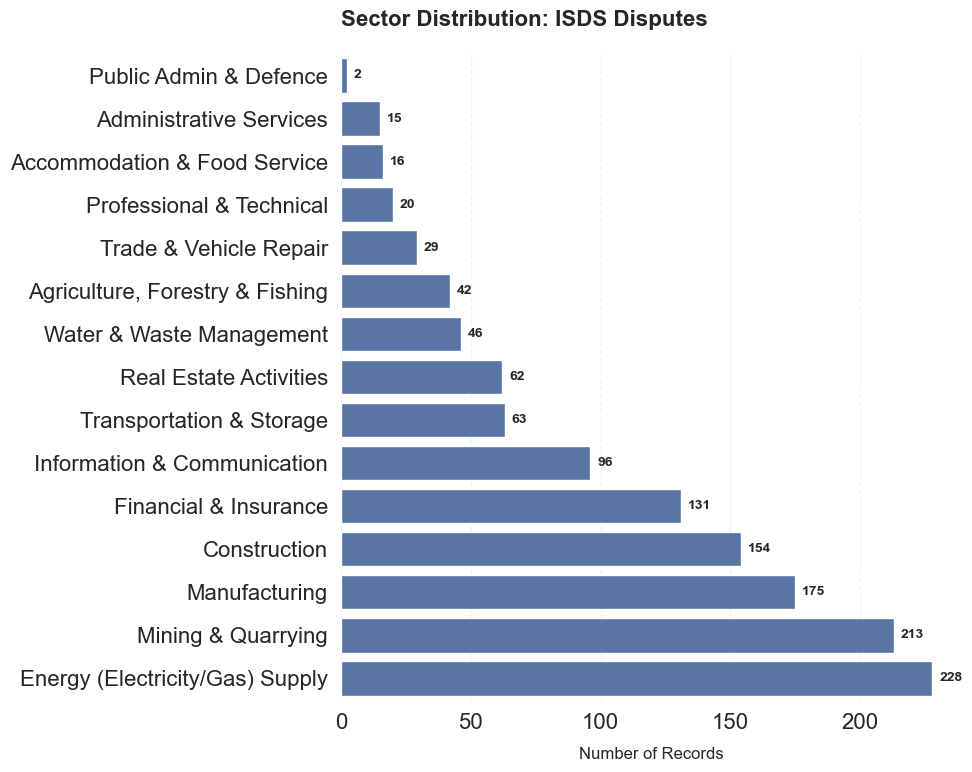

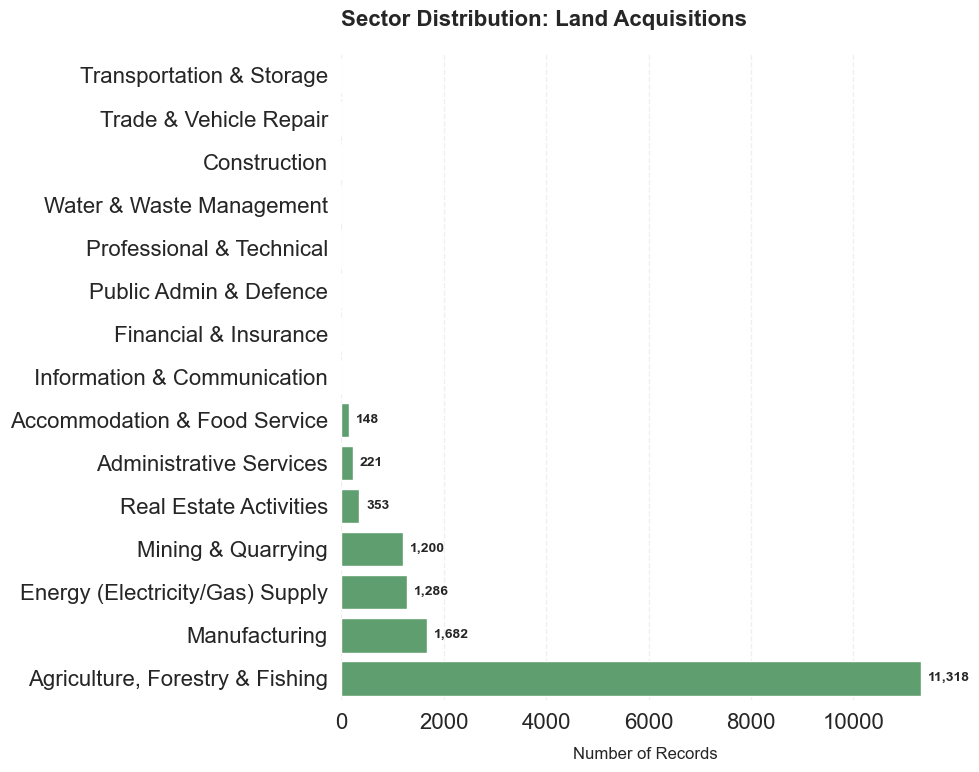

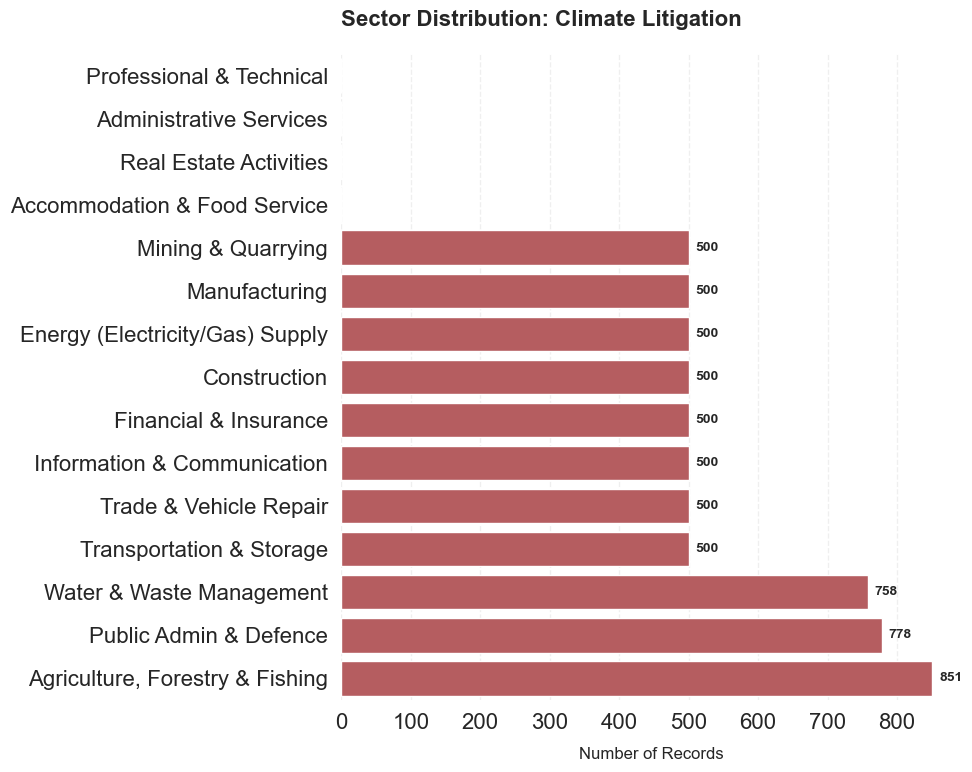

In [5]:
# recall the Sector Taxonomy mapping
sector_map = {
    'sector_A': 'Agriculture, Forestry & Fishing',
    'sector_B': 'Mining & Quarrying',
    'sector_C': 'Manufacturing',
    'sector_D': 'Energy (Electricity/Gas) Supply',
    'sector_E': 'Water & Waste Management',
    'sector_F': 'Construction',
    'sector_G': 'Trade & Vehicle Repair',
    'sector_H': 'Transportation & Storage',
    'sector_I': 'Accommodation & Food Service',
    'sector_J': 'Information & Communication',
    'sector_K': 'Financial & Insurance',
    'sector_L': 'Real Estate Activities',
    'sector_M': 'Professional & Technical',
    'sector_N': 'Administrative Services',
    'sector_O': 'Public Admin & Defence'
}

# Function to process datasets and aggregate sector counts
def get_sector_counts(file):
    df = file
    # Filter for the sector columns present in the file
    cols = [c for c in sector_map.keys() if c in df.columns]
    sums = df[cols].sum().reset_index()
    sums.columns = ['sector_id', 'count']
    sums['sector_name'] = sums['sector_id'].map(sector_map)
    # sort ascending for horizontal plot
    return sums.sort_values(by='count', ascending=True)

# Load the data
isds_data = get_sector_counts(isds)
land_data = get_sector_counts(land)
climate_data = get_sector_counts(climate)

#Standardizing plotting
def create_sector_plot(df, title, color, filename):
    plt.figure(figsize=(10, 8))
    sns.set_style("white")
    
    #setting a horizontal bar chart
    ax = sns.barplot(data=df, x='count', y='sector_name', color=color)
    
    # Adding direct labels 
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            ax.annotate(f'{int(width):,}', 
                        (width, p.get_y() + p.get_height() / 2),
                        ha='left', va='center', 
                        xytext=(5, 0), 
                        textcoords='offset points',
                        fontsize=10, fontweight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold', loc='left', pad=20)
    plt.xlabel('Number of Records', fontsize=12, labelpad=10)
    plt.ylabel('')

    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.show()

# Generate and saving the three separate plots
create_sector_plot(isds_data, "Sector Distribution: ISDS Disputes", "#4C72B0", "plot_isds_sectors.png")
create_sector_plot(land_data, "Sector Distribution: Land Acquisitions", "#55A868", "plot_land_sectors.png")
create_sector_plot(climate_data, "Sector Distribution: Climate Litigation", "#C44E52", "plot_climate_sectors.png")

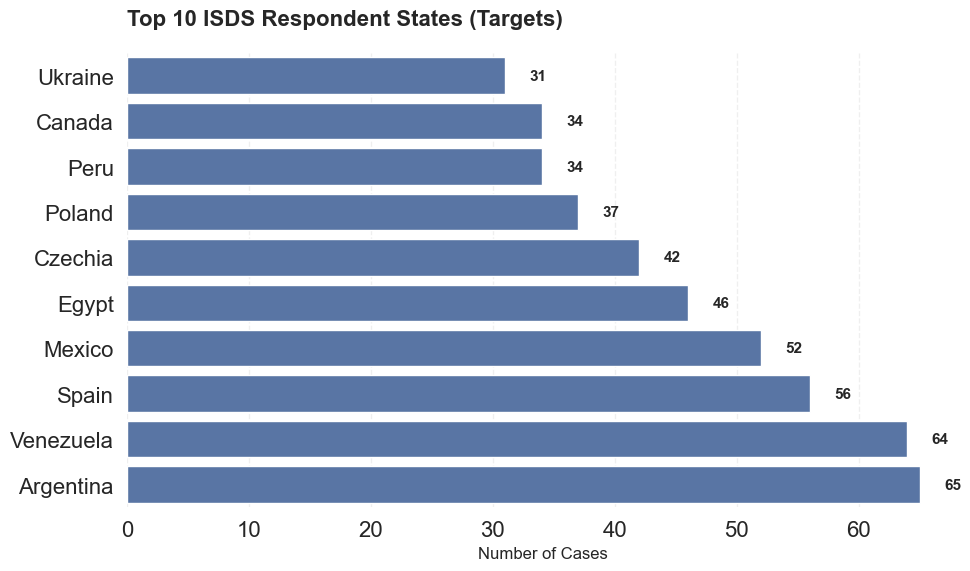

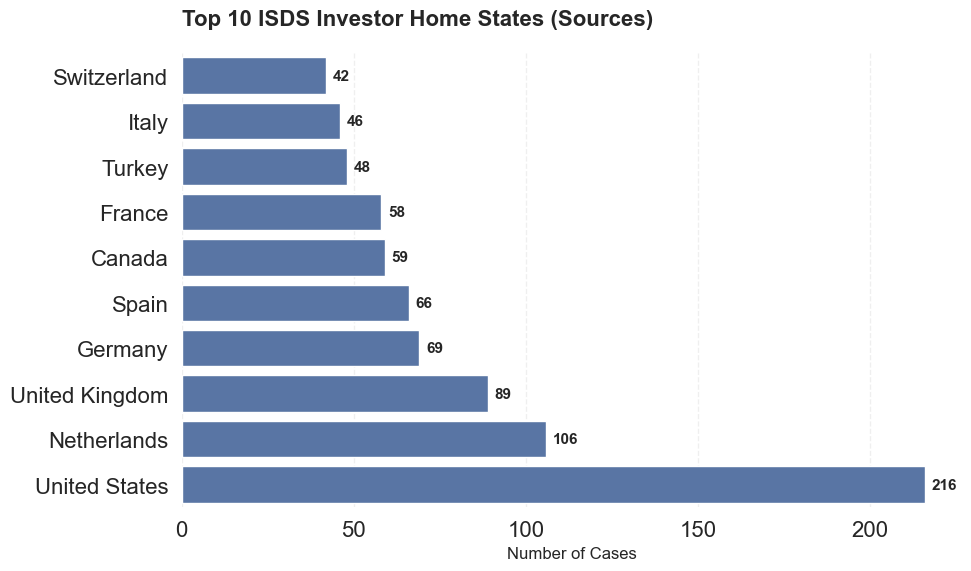

In [6]:
#Load independent variables
indep = pd.read_csv('combined_independent_variables.csv')

# Getting standardized country codes (again)
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Calculating top 10 respondent and investor counts
resp_counts = isds['resp_iso3'].value_counts().head(10).reset_index()
resp_counts.columns = ['iso3', 'count']

inv_counts = isds['inv_iso3'].value_counts().head(10).reset_index()
inv_counts.columns = ['iso3', 'count']

# getting full country names
name_map = dict(zip(indep['iso3'], indep['Country']))
resp_counts['Country'] = resp_counts['iso3'].map(name_map).fillna(resp_counts['iso3'])
inv_counts['Country'] = inv_counts['iso3'].map(name_map).fillna(inv_counts['iso3'])

# Plotting function
def isds_plot(df, title, filename, color='#4C72B0'):
    plt.figure(figsize=(10, 6))
    sns.set_style("white") 
    df_sorted = df.sort_values(by='count', ascending=True)
    ax = sns.barplot(x='count', y='Country', data=df_sorted, color=color)
    
    #direct labels
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 2, p.get_y() + p.get_height()/2, f'{int(width)}', 
                 va='center', fontweight='bold', fontsize=11)
    
    plt.title(title, fontsize=16, fontweight='bold', loc='left', pad=20)
    plt.xlabel('Number of Cases', fontsize=12)
    plt.ylabel('')
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)

#generating plots using the function
isds_plot(resp_counts, "Top 10 ISDS Respondent States (Targets)", "isds_top_respondents.png")
isds_plot(inv_counts, "Top 10 ISDS Investor Home States (Sources)", "isds_top_investors.png")

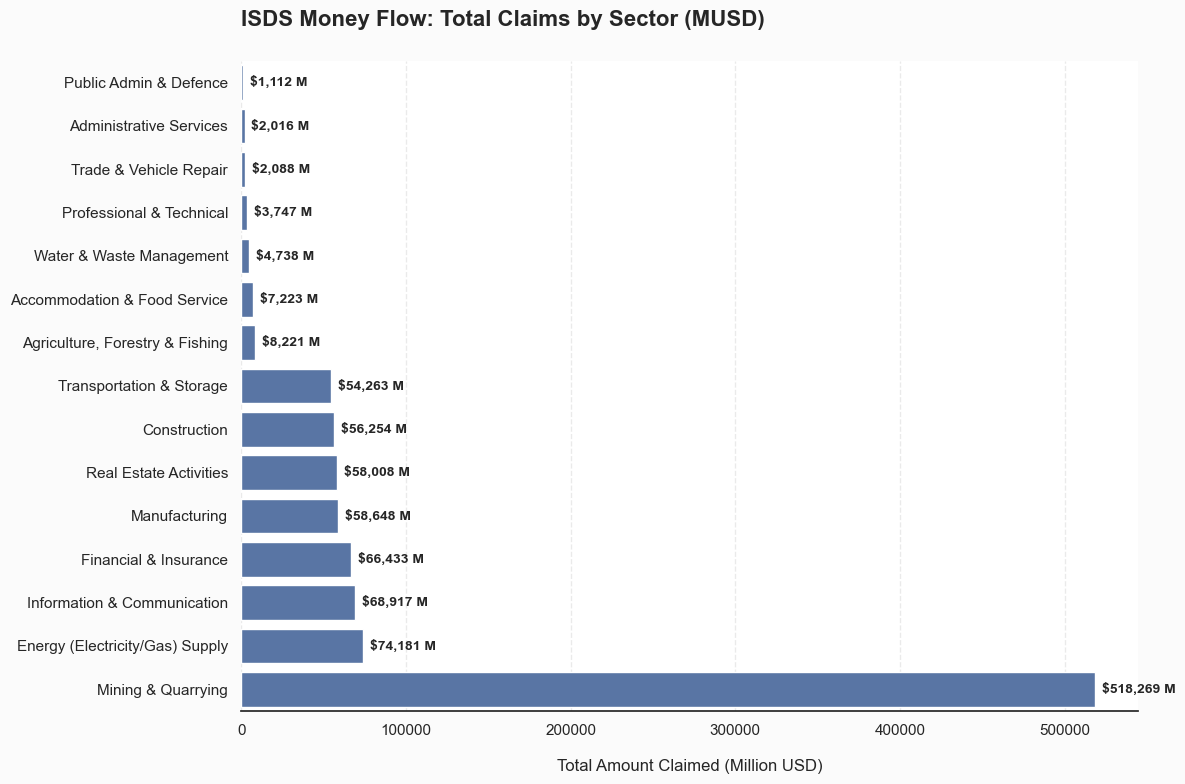

In [7]:
# Calculating ISDS claims by sector
sector_money = []
for col, name in sector_map.items():
    if col in isds.columns:
        # Sum the amount claimed for cases marked with '1' in the binary sector column
        total = isds[isds[col] == 1]['amount_claimed_musd'].sum()
        sector_money.append({'Sector': name, 'Amount_MUSD': total})

#Creating the df for visualization
df_money = pd.DataFrame(sector_money).sort_values(by='Amount_MUSD', ascending=True)

#plotting
plt.figure(figsize=(12, 8), facecolor='#fbfbfb')
sns.set_theme(style="white")
isds_blue = '#4C72B0' # consistent ISDS blue colorscheme

ax = sns.barplot(x='Amount_MUSD', y='Sector', data=df_money, color=isds_blue)

# direct labelling
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'${width:,.0f} M', 
                    (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', 
                    xytext=(5, 0), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')


plt.title('ISDS Money Flow: Total Claims by Sector (MUSD)', fontsize=16, fontweight='bold', loc='left', pad=25)
plt.xlabel('Total Amount Claimed (Million USD)', fontsize=12, labelpad=15)
plt.ylabel('')
sns.despine(left=True, bottom=False)
plt.grid(axis='x', linestyle='--', alpha=0.4) # subtle guide lines for readability but not needed here 

plt.tight_layout()
plt.savefig('isds_money_flow_by_sector.pdf')
plt.show()

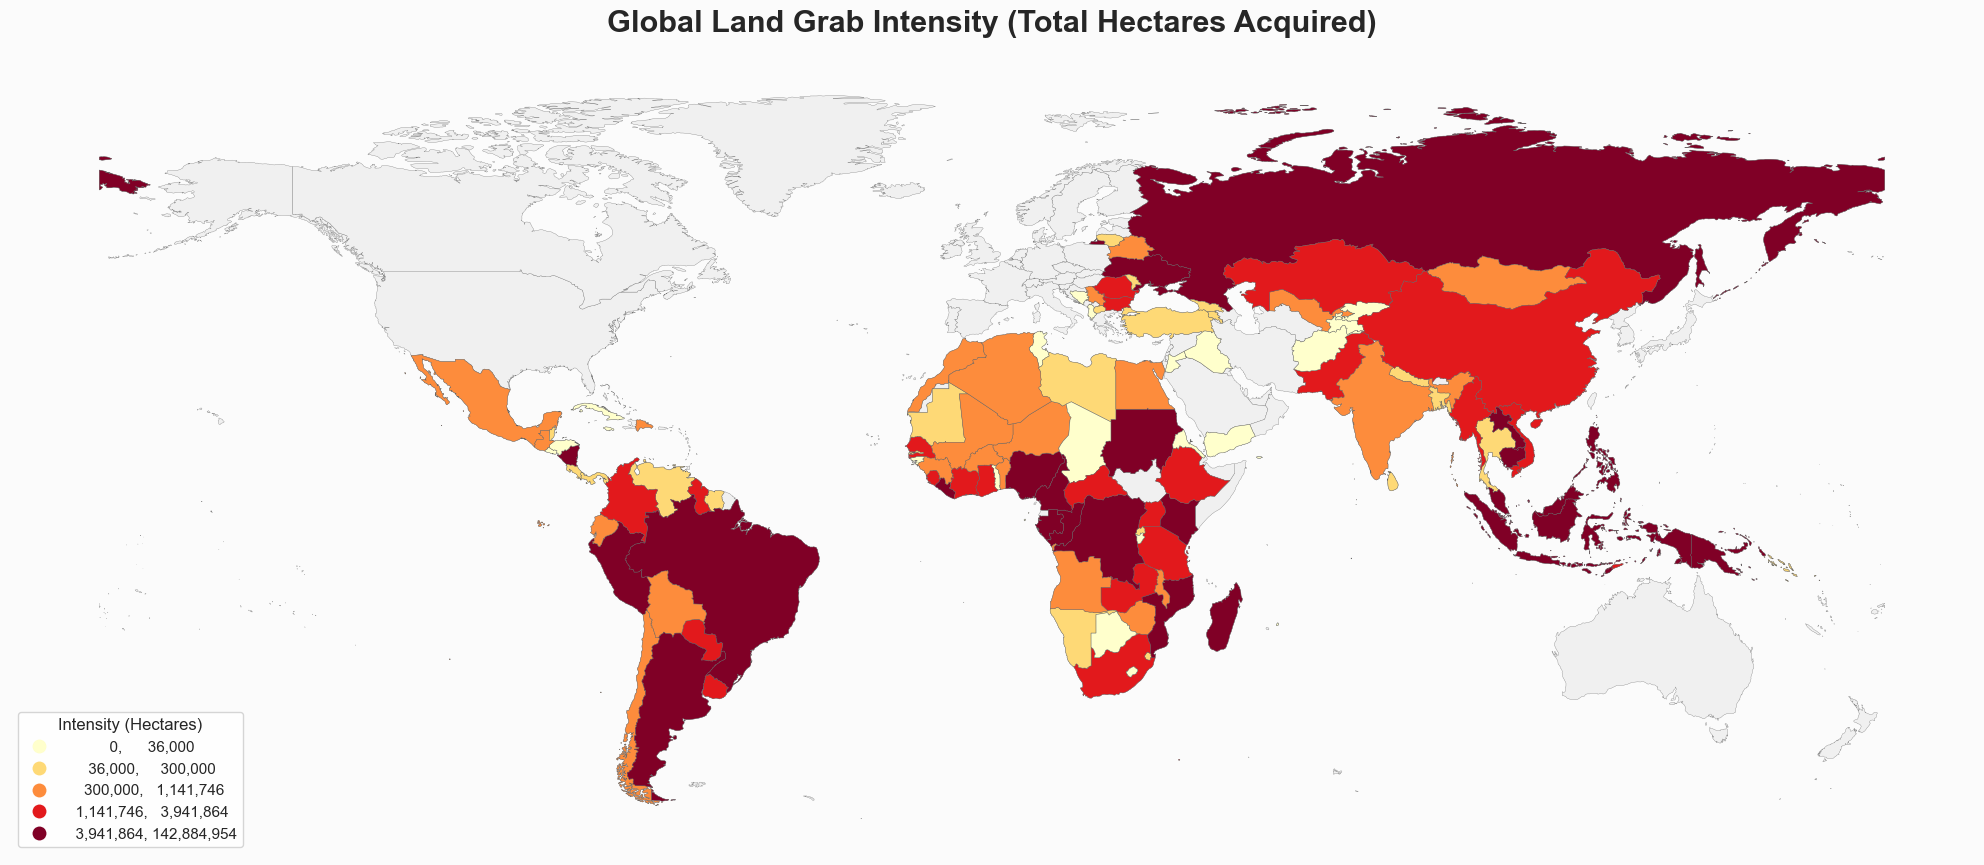

In [10]:
import geopandas as gpd

#Loading in a world map that works with ISO3
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

# Preparing land matrix data
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()

#Groupby country and take total hectares for every country
global_land = land.groupby('iso3')['Deal size'].sum().reset_index()
global_land.columns = ['iso3', 'total_hectares']

# Merge the data with the imported World Geometry
map_df = world.merge(global_land, on='iso3', how='left')

# Plotting the Map 
fig, ax = plt.subplots(figsize=(20, 10), facecolor='#fbfbfb')

# Background Layer (missing data color)
world.plot(ax=ax, color='#f0f0f0', edgecolor='#636363', linewidth=0.2)

# Choropleth layer: using quantiles
# using YlOrRd is the standard sequential colormap for 'Intensity'
map_df.dropna(subset=['total_hectares']).plot(
    column='total_hectares',
    ax=ax,
    cmap='YlOrRd',
    scheme='quantiles', 
    k=5,               # 5 bins
    legend=True,
    legend_kwds={
        'loc': 'lower left',
        'title': 'Intensity (Hectares)',
        'fmt': "{:,.0f}",
        'frameon': True
    },
    edgecolor='#636363',
    linewidth=0.3)

plt.title("Global Land Grab Intensity (Total Hectares Acquired)", fontsize=22, fontweight='bold', pad=20)
plt.axis('off')

# Zoom into the legend to make it readable
plt.tight_layout()
plt.show()

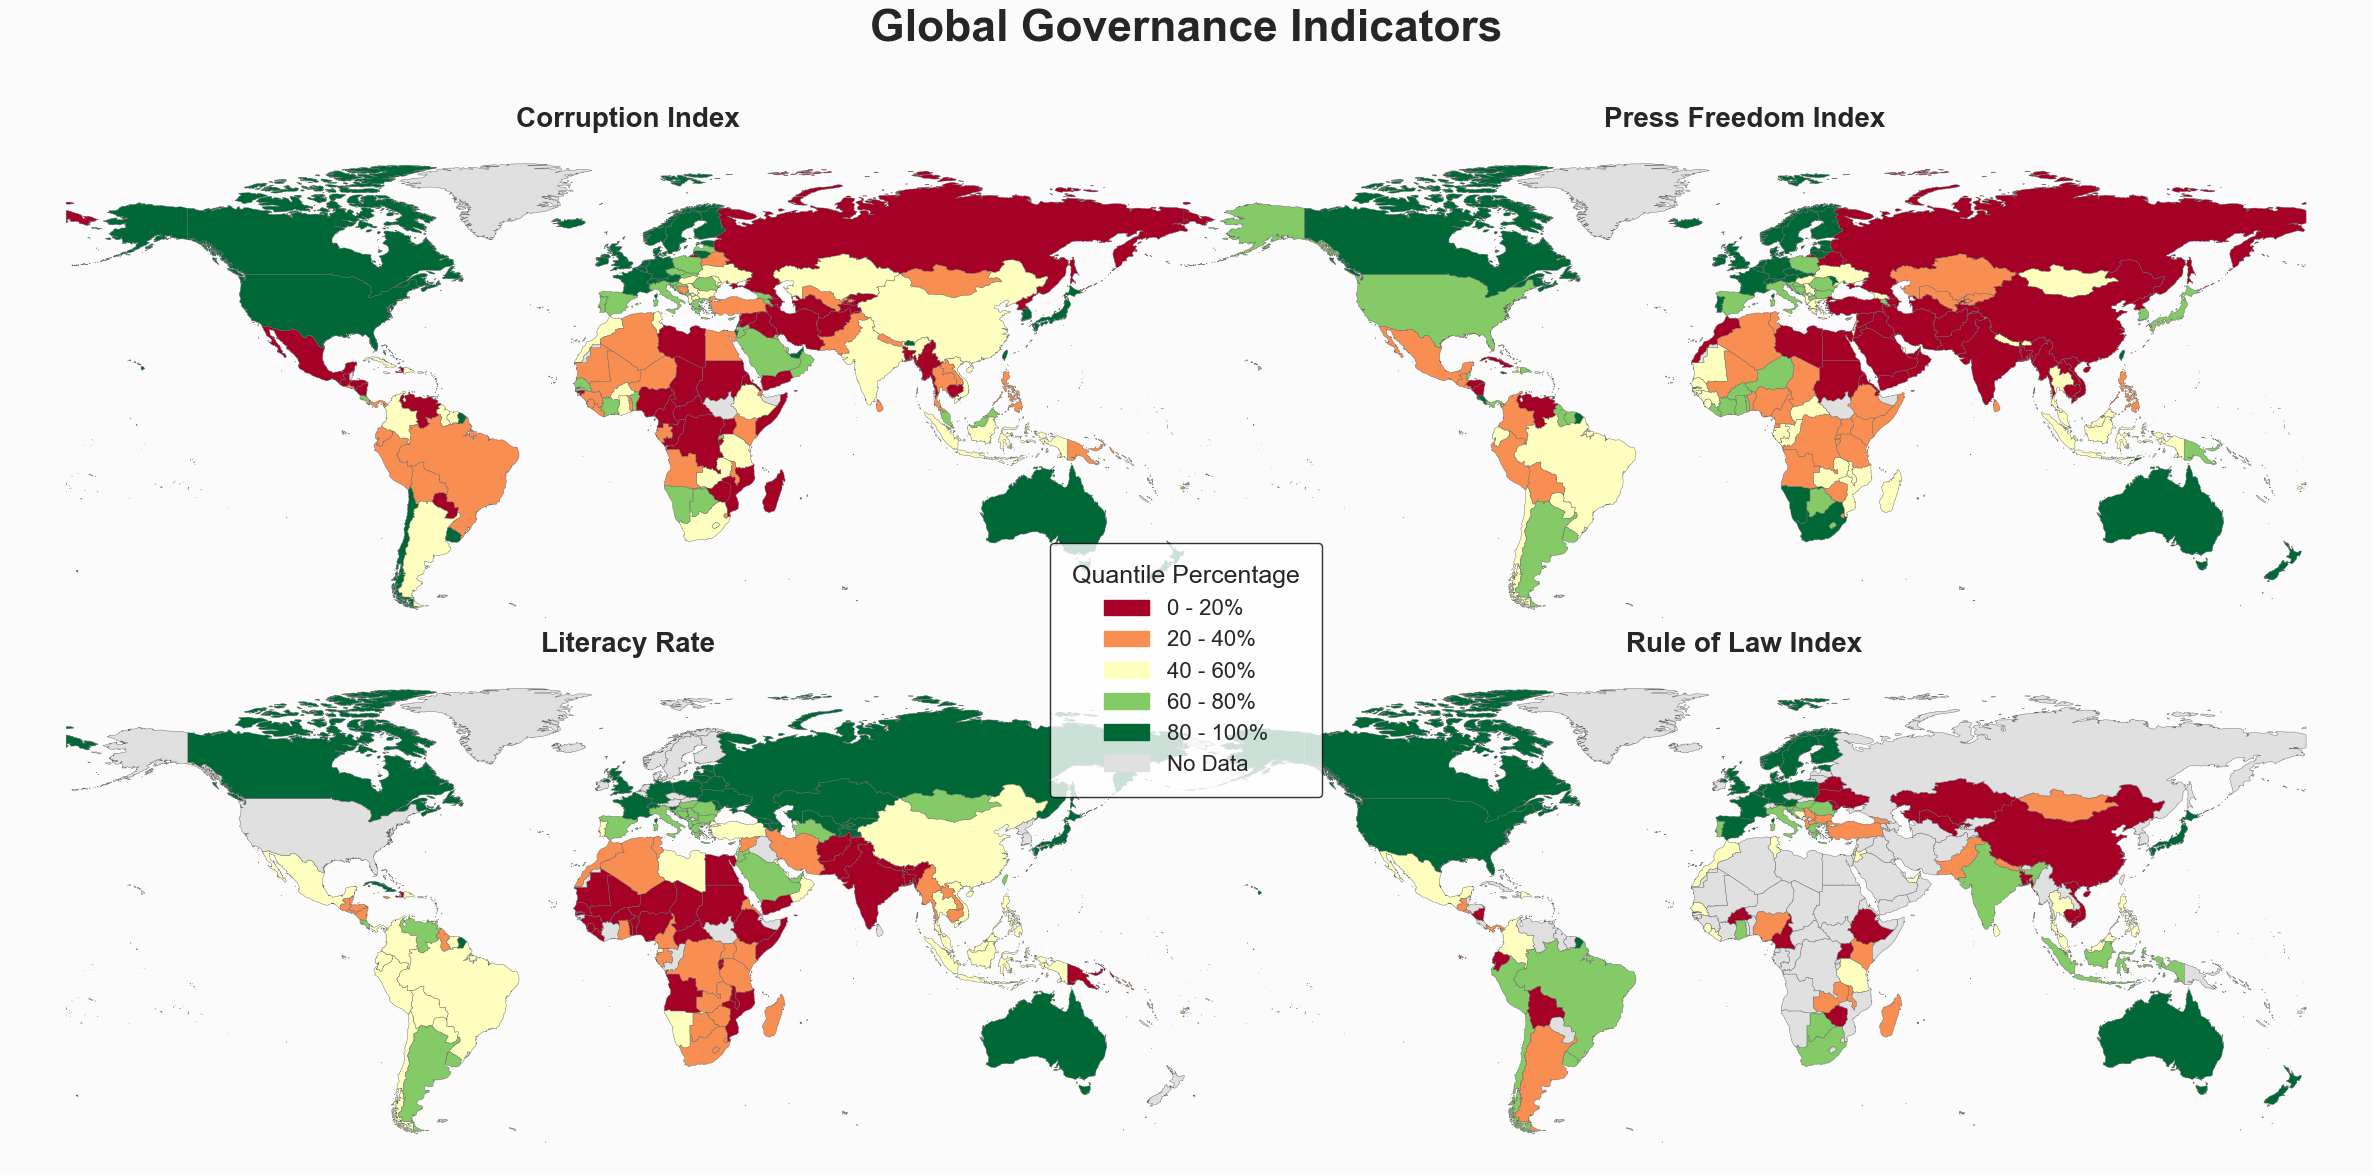

In [ ]:
import matplotlib.patches as mpatches

#general style
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 20,
    "axes.labelsize": 16
})

# Preparing the independent variable governance data
indep['iso3'] = indep['ISO3'].str.strip().str.upper()
map_df = world.merge(indep, on='iso3', how='left')

# Setup 2x2 Plot
# Removing (%) from 'Literacy Rate' title
indicators = [
    ('Corruption_Score', 'Corruption Index'),
    ('Press_Freedom_Score', 'Press Freedom Index'),
    ('Literacy_Rate_Pct', 'Literacy Rate'),
    ('Rule_of_Law_Score_Pct', 'Rule of Law Index')
]

fig, axes = plt.subplots(2, 2, figsize=(24, 12), facecolor='#fbfbfb')
axes = axes.flatten()

cmap = plt.get_cmap('RdYlGn')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
#clear labels for the quantiles
pct_labels = ["0 - 20%", "20 - 40%", "40 - 60%", "60 - 80%", "80 - 100%"]

for i, (col, title) in enumerate(indicators):
    ax = axes[i]
    map_df.plot(
        column=col,
        ax=ax,
        cmap='RdYlGn',
        scheme='quantiles',
        k=5,
        legend=False, 
        missing_kwds={"color": "#e0e0e0"},
        edgecolor='#636363',
        linewidth=0.3)
    ax.set_title(title, fontweight='bold', pad=10)
    ax.axis('off')

# creating 1 legend in the middle of the plot
legend_patches = [mpatches.Patch(color=colors[i], label=pct_labels[i]) for i in range(5)]
legend_patches.append(mpatches.Patch(color='#e0e0e0', label='No Data'))

fig.legend(
    handles=legend_patches,
    bbox_to_anchor=(0.5, 0.43), # positioning slightly down from center
    loc='center',
    ncol=1,
    fontsize=16,
    title="Quantile Percentage",
    title_fontsize=18,
    frameon=True,
    facecolor='white',
    edgecolor='black',
    borderpad=1)

plt.suptitle(
    "Global Governance Indicators",
    fontsize=32, fontweight='bold', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(wspace=-0.1, hspace=0.05) 

plt.savefig('Governance_Indicators_Central_Legend.png', dpi=600, bbox_inches='tight')
plt.show()

SUMMARY STATISTICS
       Corruption_Score  Press_Freedom_Score  Literacy_Rate_Pct  \
count        181.000000           181.000000         157.000000   
mean          42.541436            58.362873          86.101911   
std           19.309315            16.934856          17.867455   
min            8.000000            21.720000          27.000000   
25%           27.000000            45.850000          80.000000   
50%           40.000000            59.160000          95.000000   
75%           56.000000            71.060000          99.000000   
max           90.000000            95.180000         100.000000   

       Rule_of_Law_Score_Pct  
count              89.000000  
mean               57.560726  
std                16.929911  
min                23.712807  
25%                45.757113  
50%                55.258648  
75%                71.324941  
max                92.751618  
MISSING DATA
Corruption_Score          10
Press_Freedom_Score       10
Literacy_Rate_Pct         3

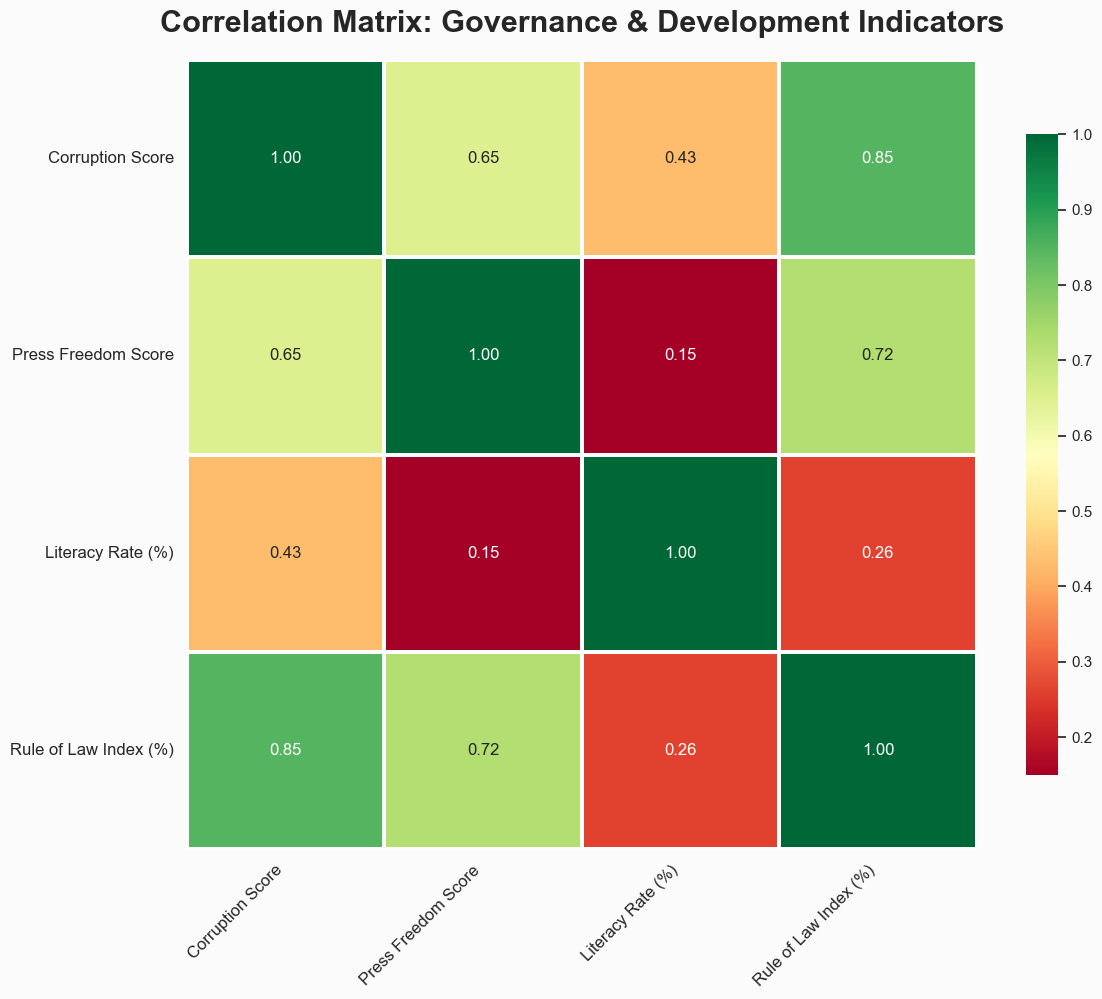

In [ ]:
#Defining labels again for the indicators to make them readable on the plot
labels = {
    'Corruption_Score': 'Corruption Score',
    'Press_Freedom_Score': 'Press Freedom Score',
    'Literacy_Rate_Pct': 'Literacy Rate (%)',
    'Rule_of_Law_Score_Pct': 'Rule of Law Index (%)'
}

indicators = list(labels.keys())

# Gathering some summary statistics
print("SUMMARY STATISTICS")
print(indep[indicators].describe())

print("MISSING DATA")
print(indep[indicators].isnull().sum())

# Creating a correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fbfbfb')

sns.set_theme(style="white")

# Calculating correlation and renaming for the heatmap labels
corr = indep[indicators].corr()
corr.columns = [labels[col] for col in corr.columns]
corr.index =[ labels[col] for col in corr.index]

#drawing the heatmap
sns.heatmap(
    corr, 
    annot=True, 
    cmap='RdYlGn', 
    fmt=".2f", 
    linewidths=1.5,
    cbar_kws={"shrink": .8},
    square=True,
    ax=ax)

plt.title('Correlation Matrix: Governance & Development Indicators', 
          fontsize=22, fontweight='bold', pad=20)

# Rotating X labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.savefig('governance_correlation_heatmap_final.png', dpi=600)
plt.show()

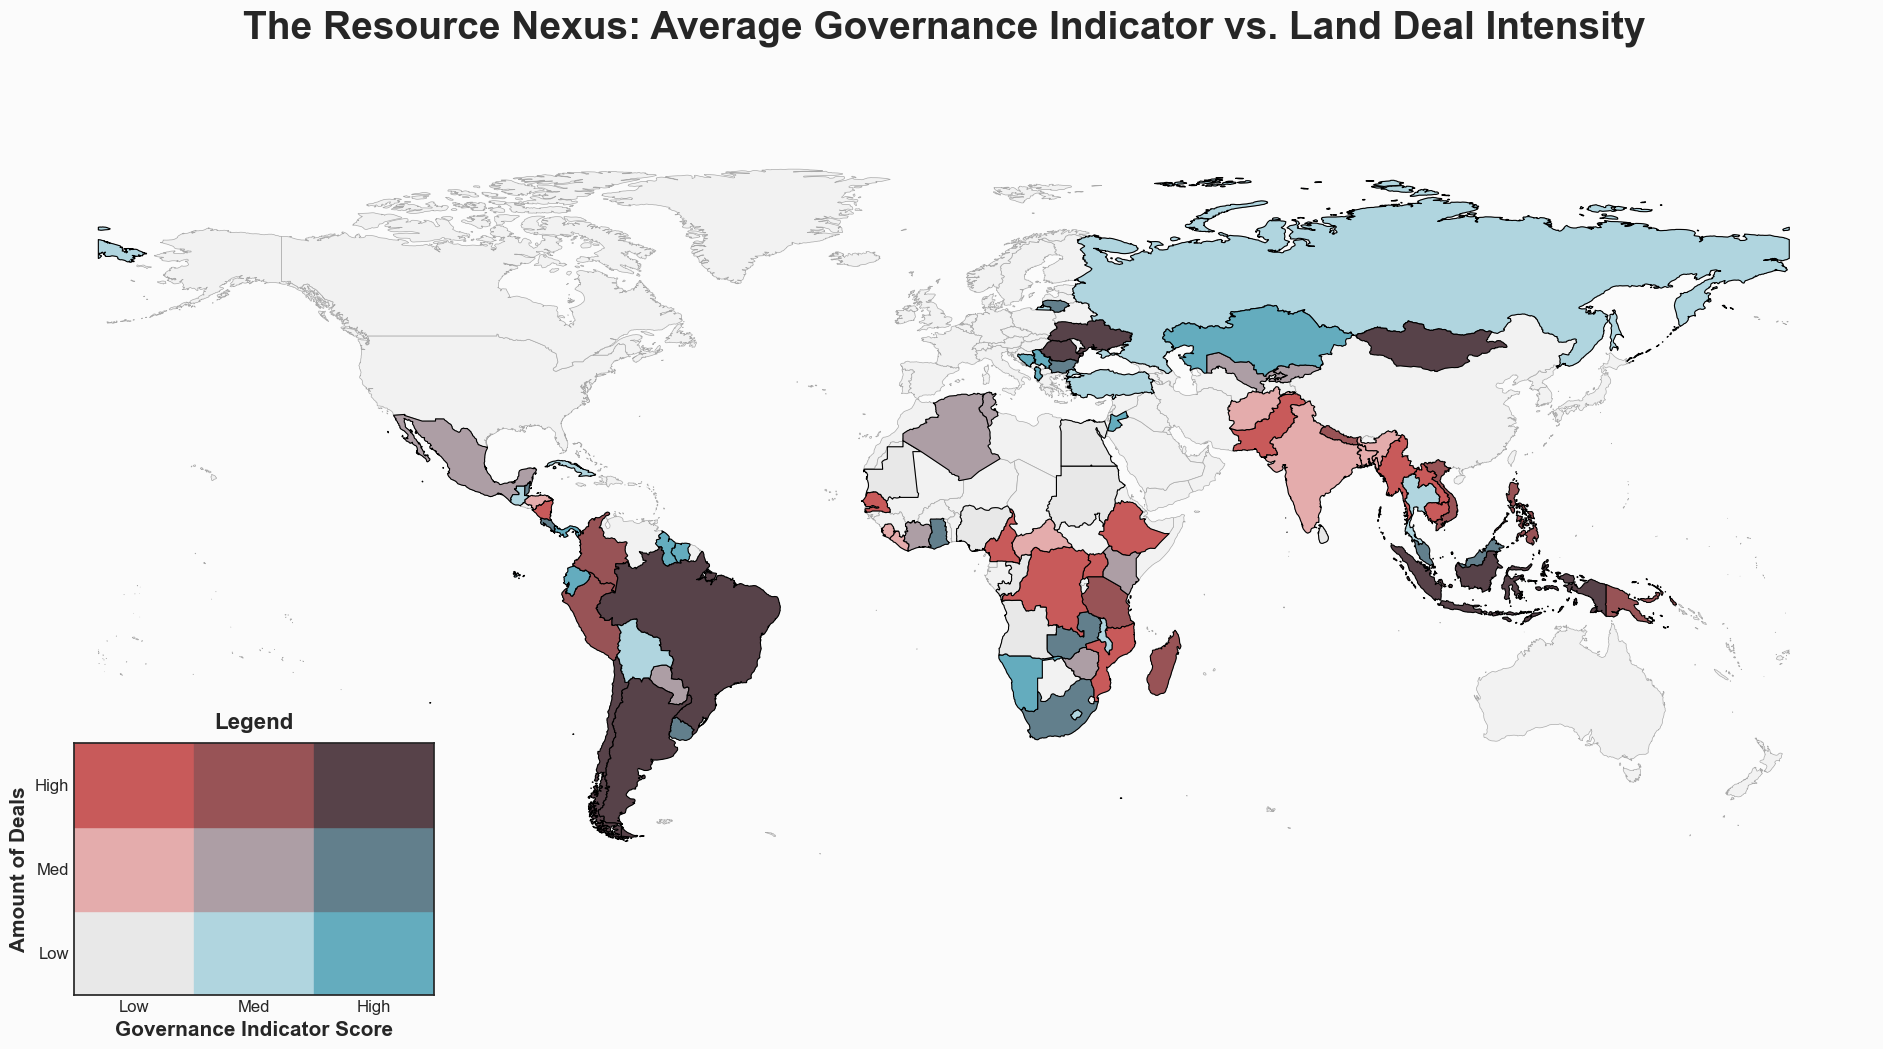

In [ ]:
import geopandas as gpd

#setting general style and colors
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 28,
    "axes.labelsize": 18
})

bivariate_colors = [
    "#e8e8e8", "#b0d5df", "#64acbe", # Low Y: grey -> blue
    "#e4acac", "#ad9ea5", "#627f8c", # Med Y
    "#c85a5a", "#985356", "#574249"  # High Y: red -> dark
    ]
#setting up a function to get the right color
def get_bivariate_color(val_x, val_y):
    if pd.isna(val_x) or pd.isna(val_y): return None
    return bivariate_colors[int(val_x + val_y * 3)]
#quantile classification bin creating functuin using  using ranks
def create_bins(df, column):
    return pd.qcut(df[column].rank(method='first'), 3, labels=[0, 1, 2]).astype(int)



# Standardizing ISOs (general starting point to see what we are using)
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
land['investor_iso3'] = land['Investor_Country of registration/origin_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Normalize the independent variables to range 0-1, closer to 1 is better!
cols_to_norm = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct']
for col in cols_to_norm:
    min_val = indep[col].min()
    max_val = indep[col].max()
    indep[f'{col}_norm'] = (indep[col] - min_val) / (max_val - min_val)

#Calculating the average of normalized scores
# Dropping rows where any of the three are missing to ensure a consistent index
norm_cols = [f'{col}_norm' for col in cols_to_norm]
indep['inst_quality_composite'] = indep[norm_cols].mean(axis=1)

# Getting only transnational land deals and the intensity of it by using groupby countries
trans = land[land['iso3'] != land['investor_iso3']].copy()
intensity = trans.groupby('iso3').size().reset_index(name='total_intensity')

# Merging both dataframes
df_biv = indep[['iso3', 'inst_quality_composite']].merge(intensity, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'total_intensity']).copy()

# calculating the bivariate bins and colors using the earlier defined functions
df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'total_intensity')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)


#plotting
fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background layer of the world
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Data layer with black borders for visibility
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])

if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

ax.set_title("The Resource Nexus: Average Governance Indicator vs. Land Deal Intensity", 
             fontweight='bold', pad=70, loc='center')

# Bivariate legend
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3); leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_xlabel('Governance Indicator Score', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Amount of Deals', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('composite_quality_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

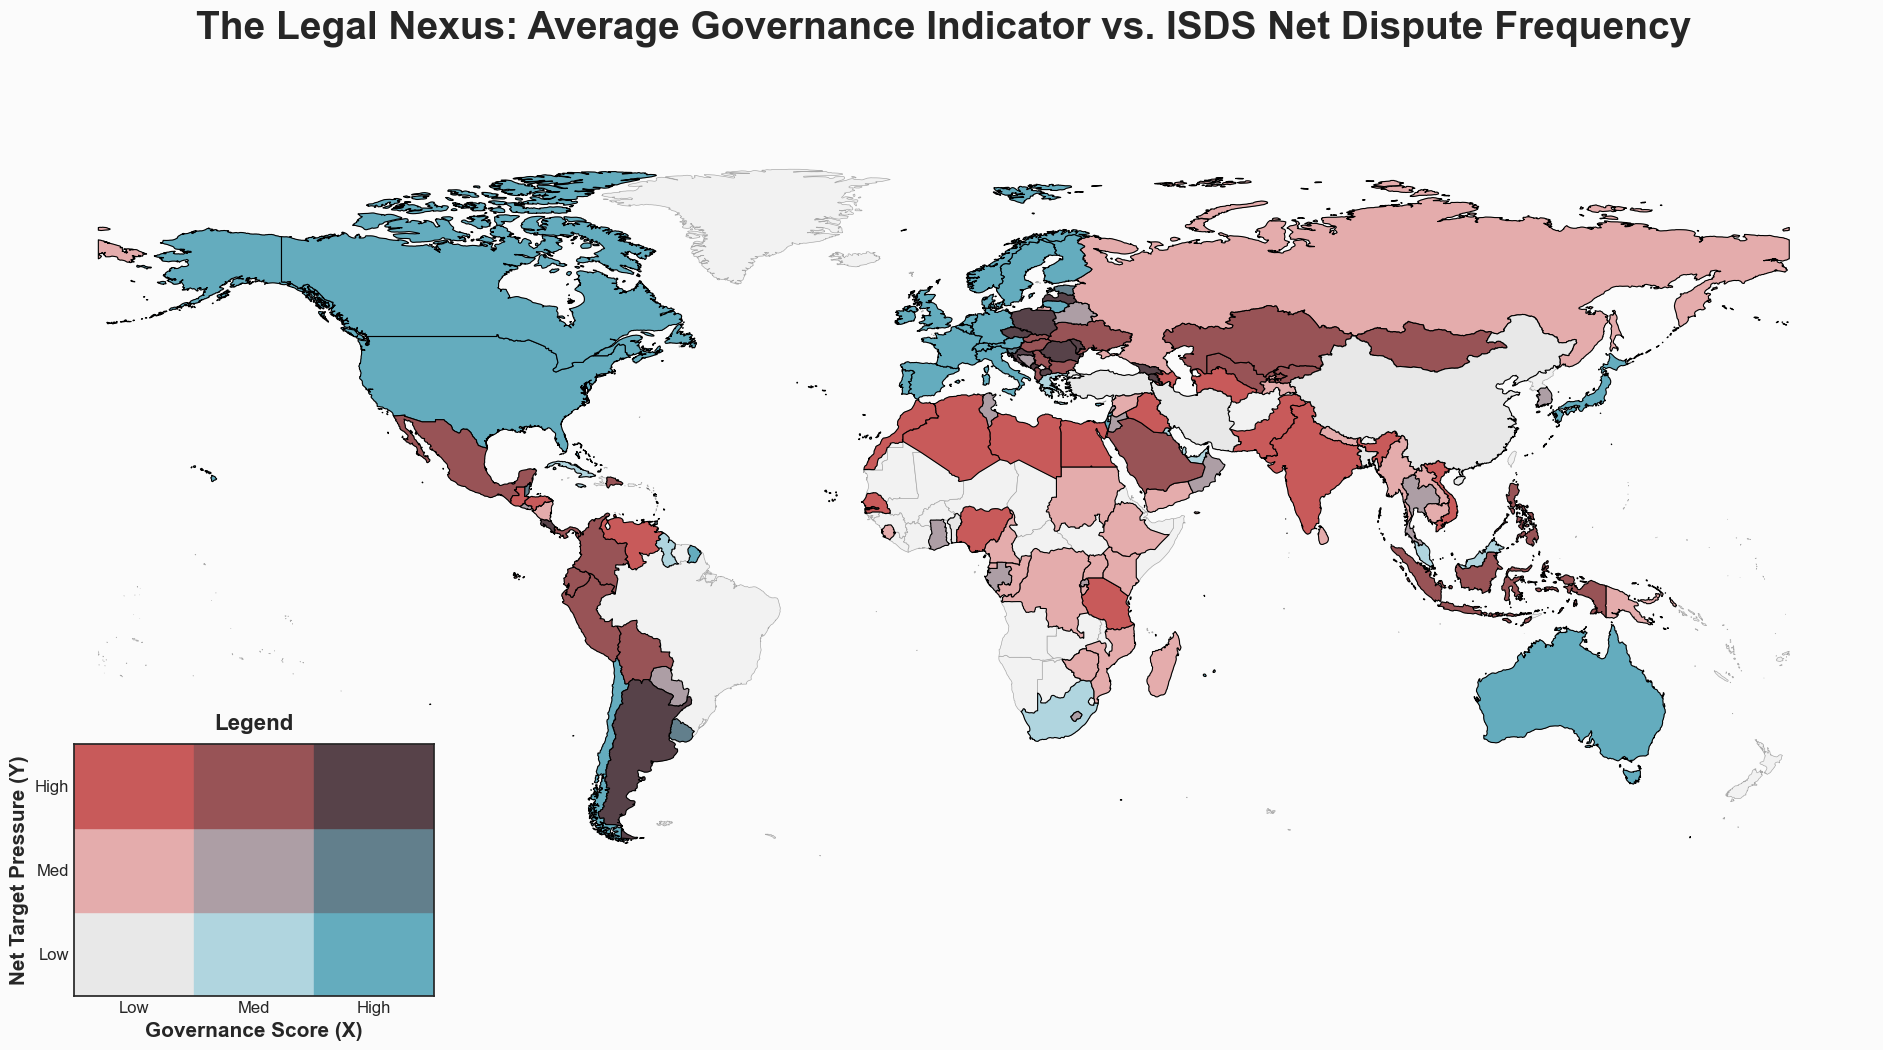

In [ ]:
# ISOs tables
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

#calculating the net ISDS cases per country again
#isds cases are in general transnational but still checking it
isds_trans = isds[isds['inv_iso3'] != isds['resp_iso3']].copy()

inv_counts = isds_trans['inv_iso3'].value_counts().reset_index()
inv_counts.columns = ['iso3', 'investor_count']

resp_counts = isds_trans['resp_iso3'].value_counts().reset_index()
resp_counts.columns = ['iso3', 'respondent_count']

net_df = pd.merge(inv_counts, resp_counts, on='iso3', how='outer').fillna(0)
# Keep in mind: we use respondent - investor so that 'High Y' = most heavily targeted
net_df['net_targeted_pressure'] = net_df['respondent_count'] - net_df['investor_count']

#Calculating the  bins using the functions created earlier
df_biv = indep[['iso3', 'inst_quality_composite']].merge(net_df, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'net_targeted_pressure']).copy()

df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'net_targeted_pressure')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)


#Plotting
fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background layer of the world
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main data layer
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])
if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

ax.set_title("The Legal Nexus: Average Governance Indicator vs. ISDS Net Dispute Frequency", 
             fontweight='bold', pad=70, loc='center')

# Bivariate legend
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3)
leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)

leg_ax.set_xlabel('Governance Score (X)', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Net Target Pressure (Y)', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('net_isds_nexus_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

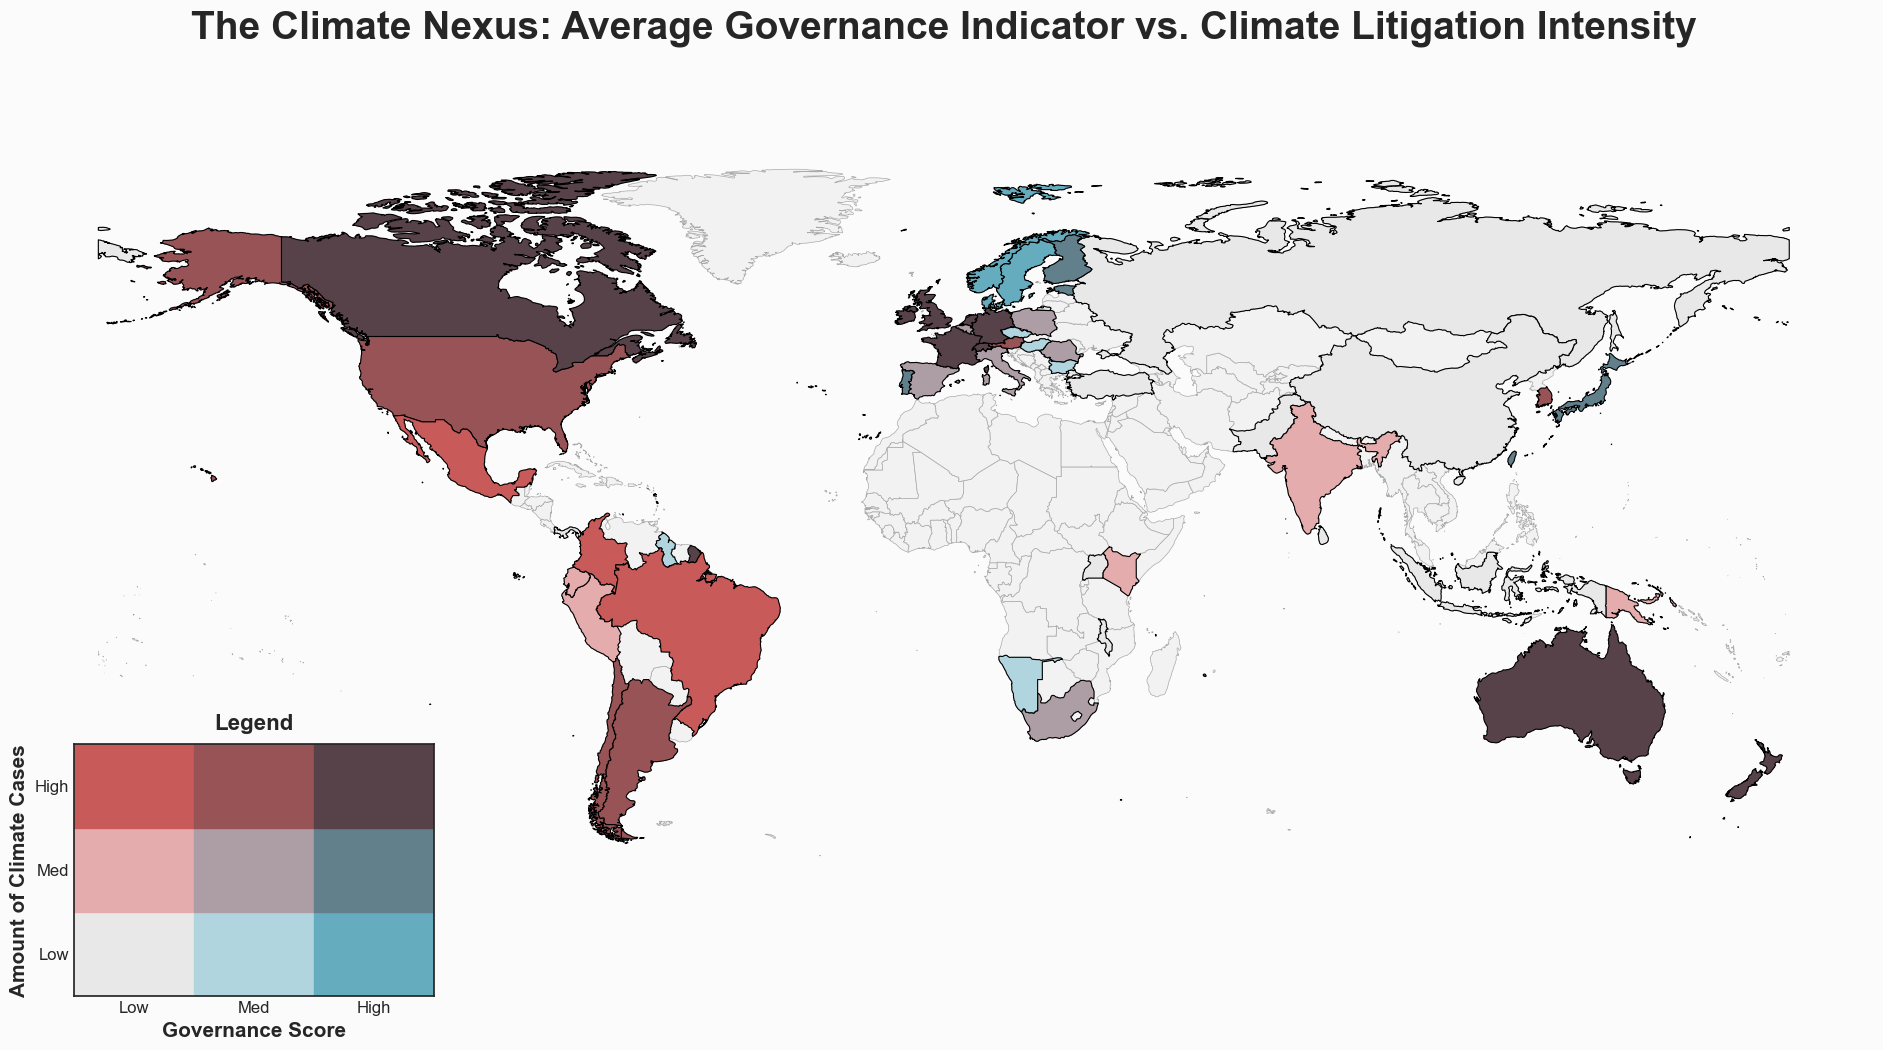

In [ ]:
# Extracting ISO3 from 'Geographies' only selecting the first value
climate['iso3'] = climate['Geographies'].str.split(';').str[0].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Count cases per country
lit_intensity = climate.groupby('iso3').size().reset_index(name='case_count')

# Merge the frames and clean
df_biv = indep[['iso3', 'inst_quality_composite']].merge(lit_intensity, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'case_count']).copy()

# Calculate Bivariate bins and colors using earlier defined functions
df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'case_count')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)

#plotting
fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background layer of the world map
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main layer
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])

if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

ax.set_title("The Climate Nexus: Average Governance Indicator vs. Climate Litigation Intensity", 
             fontweight='bold', pad=70, loc='center')

# Bivariate legend 
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3); leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_xlabel('Governance Score', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Amount of Climate Cases', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('climate_nexus_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

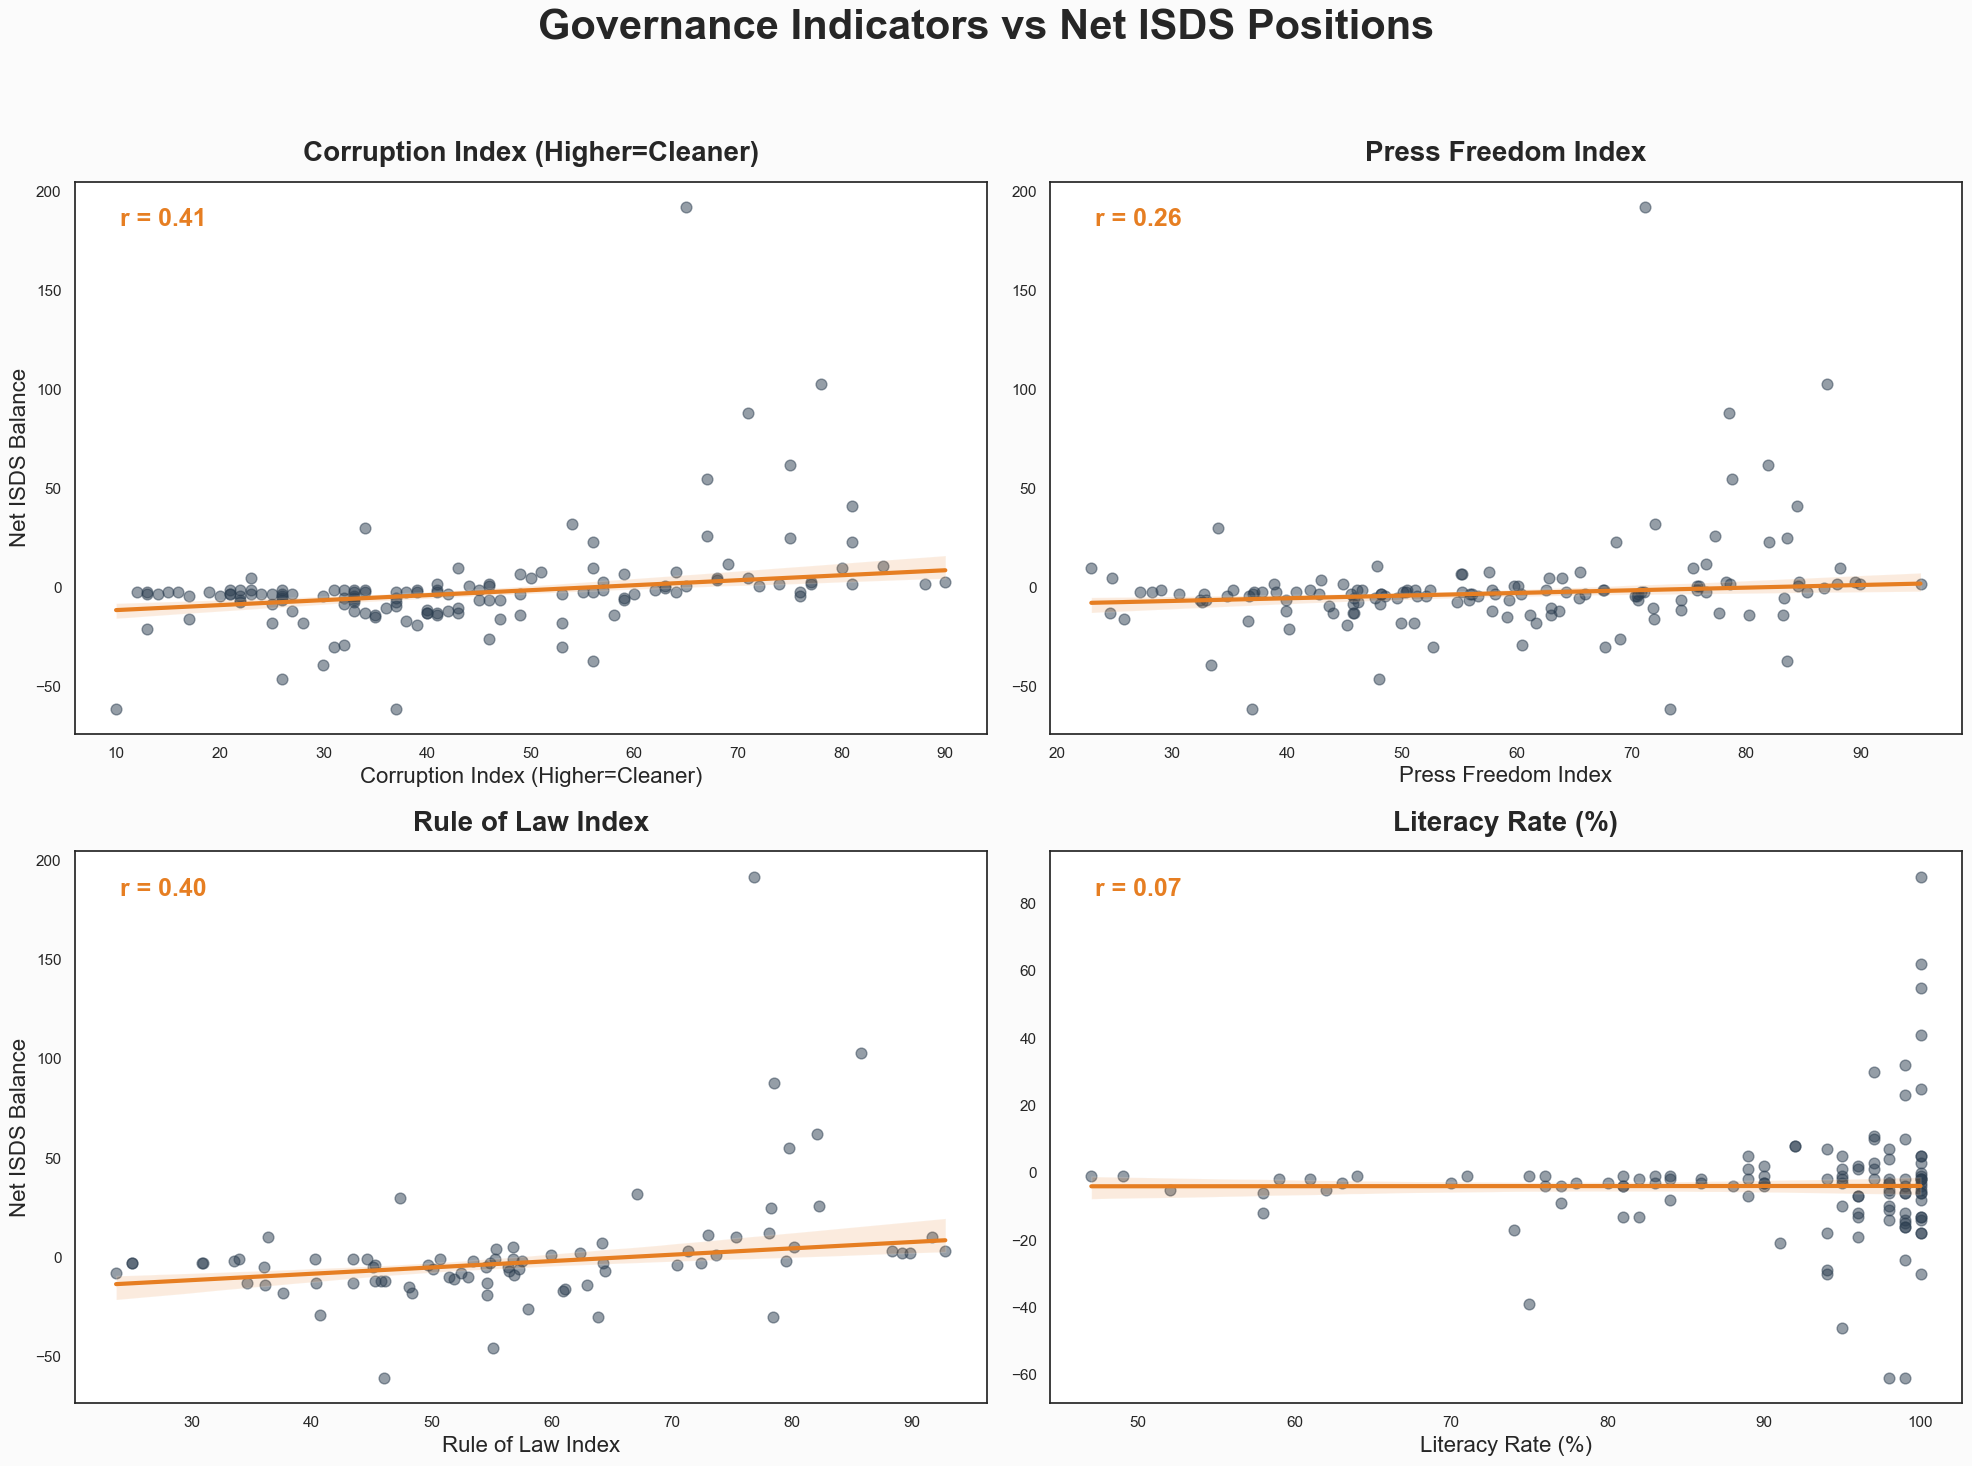

In [ ]:


# The right isocodes
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Getting the net transnational disputes per country again
isds_trans = isds[isds['inv_iso3'] != isds['resp_iso3']].copy()

inv_counts = isds_trans['inv_iso3'].value_counts().reset_index()
inv_counts.columns = ['iso3', 'investor_count']

resp_counts = isds_trans['resp_iso3'].value_counts().reset_index()
resp_counts.columns = ['iso3', 'respondent_count']


net_df = pd.merge(inv_counts, resp_counts, on='iso3', how='outer').fillna(0)
net_df['net_isds'] = net_df['investor_count'] - net_df['respondent_count']

# Setting up a 2x2 plot for the 4 different indipendent variables
indicators = [
    ('Corruption_Score', 'Corruption Index (Higher=Cleaner)'),
    ('Press_Freedom_Score', 'Press Freedom Index'),
    ('Rule_of_Law_Score_Pct', 'Rule of Law Index'),
    ('Literacy_Rate_Pct', 'Literacy Rate (%)')]

fig, axes = plt.subplots(2, 2, figsize=(20, 15), facecolor='#fbfbfb')
axes = axes.flatten()
sns.set_style("whitegrid")

for i, (col, label) in enumerate(indicators):
    ax = axes[i]
    
    # Merging net ISDS and the specific governance column
    # inner join handles the "missing country" issue for us by excluding them
    merged = pd.merge(net_df[['iso3', 'net_isds']], indep[['iso3', col]], on='iso3', how='inner')
    merged = merged.dropna(subset=[col, 'net_isds'])
    
    # Making a regression plot
    sns.regplot(
        data=merged, 
        x=col, 
        y='net_isds', 
        ax=ax,
        scatter_kws={'alpha':0.5, 'color':'#2c3e50', 's':60},
        line_kws={'color':'#e67e22', 'lw':3},
        robust=True)
    
    # Labeling with corelation coeff
    ax.set_title(label, fontsize=20, fontweight='bold', pad=15)
    ax.set_xlabel(label, fontsize=16)
    ax.set_ylabel("Net ISDS Balance" if i % 2 == 0 else "", fontsize=16)
    
    # Statistical context
    corr = merged[col].corr(merged['net_isds'])
    ax.text(0.05, 0.92, f'r = {corr:.2f}', transform=ax.transAxes, 
            fontsize=18, fontweight='bold', color='#e67e22')

plt.suptitle("Governance Indicators vs Net ISDS Positions", 
             fontsize=30, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('isds_net_governance_quad_analysis.png', dpi=600, bbox_inches='tight')
plt.show()